In [4]:
import warnings
warnings.filterwarnings("ignore")

In [155]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import geopandas as gpd
import folium 
from folium import plugins 

In [6]:
%matplotlib inline
plt.style.use('bmh')

In [7]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization

In [8]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, desc, explode, split, year, month, dayofweek, length, initcap, trim, lower, 
    regexp_extract, regexp_replace, max, explode, count, when)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType,
    FloatType, BooleanType, DateType, DoubleType)

In [9]:
spark = SparkSession.builder \
    .appName("Cleaned Data EDA") \
    .getOrCreate()

spark

24/11/11 19:47:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [10]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun_violence_cleaned_data_2013_2018.csv")

print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 45


In [11]:
def get_null_counts(df):
    """
    Get counts and percentages of null values in each column of a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame to analyze.

    Returns:
    DataFrame: A DataFrame containing column names, null counts, and null percentages.
    """
    total_rows = df.count()
    
    null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])

    narrow_null_counts = null_counts.selectExpr(
                                    f"'{null_counts.columns[0]}' as column_name",
                                    f"{null_counts.columns[0]} as null_count",
                                    f"({null_counts.columns[0]} / {total_rows} * 100) as null_percentage")

    for c in null_counts.columns[1:]:
        next_col = null_counts.selectExpr(f"'{c}' as column_name", 
                                          f"{c} as null_count",
                                          f"({c} / {total_rows} * 100) as null_percentage")
        narrow_null_counts = narrow_null_counts.union(next_col)
    
    narrow_null_counts = narrow_null_counts.orderBy(desc("null_count"))
    
    return narrow_null_counts

In [12]:
txt_columns = ["notes"]

ip_data = ip_data.fillna("missing", subset=txt_columns)

In [13]:
narrow_null_counts = get_null_counts(ip_data)
narrow_null_counts.show(n=5, truncate=False)

+-------------------------------------+----------+---------------+
|column_name                          |null_count|null_percentage|
+-------------------------------------+----------+---------------+
|city_or_county                       |0         |0.0            |
|participant_type_subject_suspect_freq|0         |0.0            |
|participant_status_unharmed_freq     |0         |0.0            |
|participant_type_victim_freq         |0         |0.0            |
|participant_status_injured_freq      |0         |0.0            |
+-------------------------------------+----------+---------------+
only showing top 5 rows



### Exploring the Time Related Trends

Analyzing time related trends related to Gun Violence Incidents. This includes the number of incidents which occured by years, months, and day of the week and so on.

In [116]:
pandas_ip_df = ip_data.toPandas()
pandas_ip_df['loss'] = pandas_ip_df['n_killed'] + pandas_ip_df['n_injured']

#### Gun Violence Incidents by years

In [17]:
sns.set_theme(style="whitegrid")

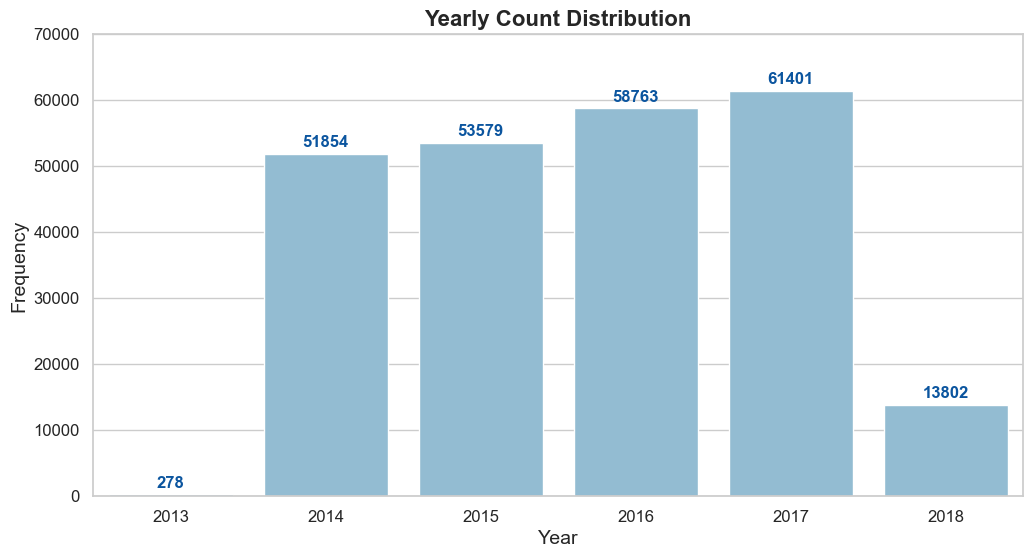

In [18]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(data=pandas_ip_df, x='year', color='#88BFDC')

plot.set_title("Yearly Count Distribution", fontsize=16, weight='bold')
plot.set_xlabel("Year", fontsize=14)
plot.set_ylabel("Frequency", fontsize=14)
plot.set_ylim(0, 70000)

plot.tick_params(labelsize=12)
for p in plot.patches:
    plot.annotate(f'{int(p.get_height())}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='baseline', fontsize=12, color='#0B559F', 
                  xytext=(0, 5), textcoords='offset points', weight='bold')

plt.show()

The graph reveals a rising trend in gun violence incidents over the years. 2013 and 2018 have only partial information of only few months that's why the less count. In 2014, approximately 51,000 incidents were reported, increasing to 53,000 in 2015. A more significant rise occurred in 2016, with nearly 58,000 incidents, followed by a further increase to 61,000 in 2017. This reflects a notable increase of 10,000 incidents from 2014 to 2017. With 2018 only halfway through, this figure is anticipated to grow even further.

#### Gun Violence Incidents by months

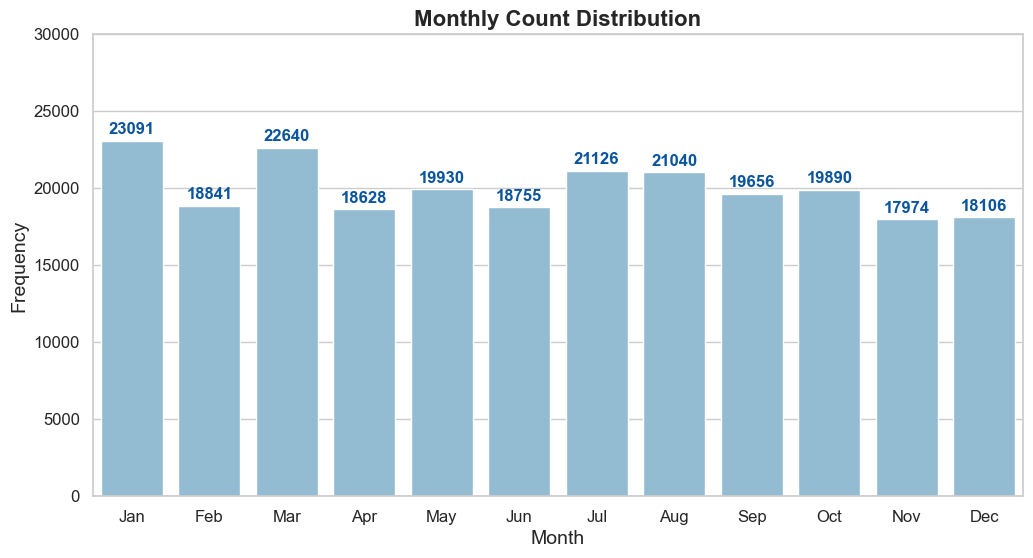

In [21]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(data=pandas_ip_df, x='month', color='#88BFDC')

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plot.set_title("Monthly Count Distribution", fontsize=16, weight='bold')
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Frequency", fontsize=14)
plot.set_ylim(0, 30000)

plot.set_xticks(range(12))
plot.set_xticklabels(month_names)

plot.tick_params(labelsize=12)
for p in plot.patches:
    plot.annotate(f'{int(p.get_height())}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='baseline', fontsize=12, color='#0B559F', 
                  xytext=(0, 5), textcoords='offset points', weight='bold')

plt.show()

`January` and `March` record the highest average number of gun violence incidents compared to other months, with around 23,000 incidents reported overall across the years.

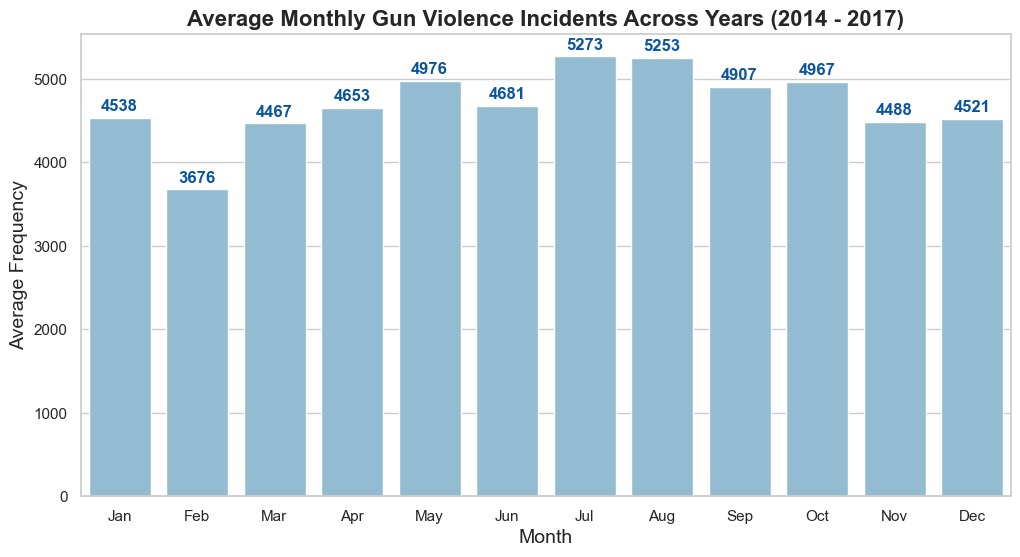

In [23]:
filtered_df = pandas_ip_df[(pandas_ip_df['year'] >= 2014) & (pandas_ip_df['year'] <= 2017)]
monthly_avg = filtered_df.groupby('month').size() / filtered_df['year'].nunique()
monthly_avg_df = monthly_avg.reset_index(name='average_incidents')
monthly_avg_df = monthly_avg_df.sort_values(by='month')

plt.figure(figsize=(12, 6))
plot = sns.barplot(data=monthly_avg_df, x='month', y='average_incidents', color='#88BFDC')
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plot.set_title("Average Monthly Gun Violence Incidents Across Years (2014 - 2017)", fontsize=16, weight='bold')
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Average Frequency", fontsize=14)
plot.set_xticklabels(month_names)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='baseline', fontsize=12, color='#0B559F', 
                  xytext=(0, 5), textcoords='offset points', weight='bold')
plt.show()

July and August record the highest average number of gun violence incidents compared to other months, with around 5,200 incidents reported each year during these months. February, on the other hand, has the lowest average, with approximately 3,700 incidents annually. In upcoming sections, I’ll investigate whether specific dates consistently show higher incident numbers.

#### Gun Violence Incidents by day of the week

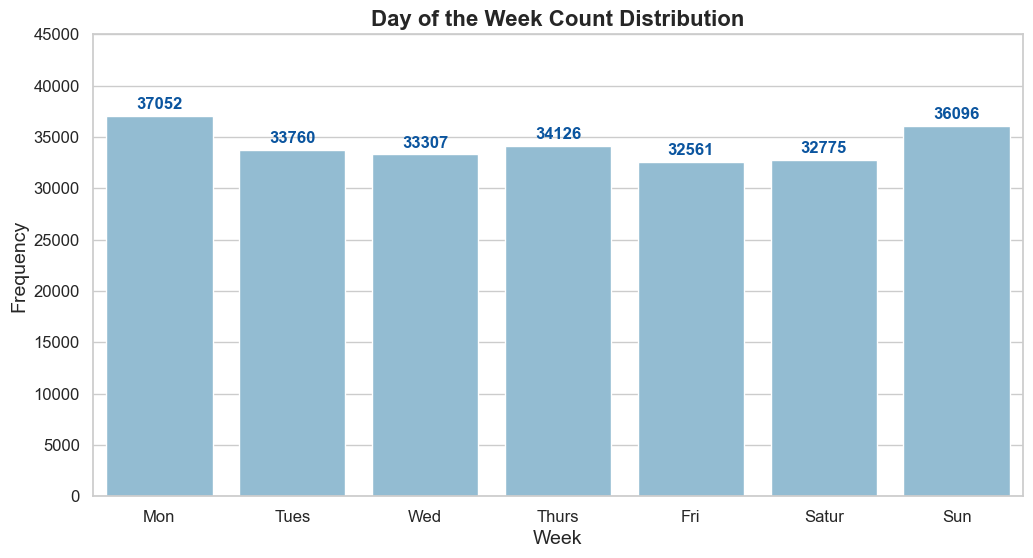

In [26]:
plt.figure(figsize=(12, 6))
plot = sns.countplot(data=pandas_ip_df, x='day_of_week', color='#88BFDC')

week_names = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Satur", "Sun"]
plot.set_title("Day of the Week Count Distribution", fontsize=16, weight='bold')
plot.set_xlabel("Week", fontsize=14)
plot.set_ylabel("Frequency", fontsize=14)
plot.set_ylim(0, 45000)

plot.set_xticks(range(7))
plot.set_xticklabels(week_names)

plot.tick_params(labelsize=12)
for p in plot.patches:
    plot.annotate(f'{int(p.get_height())}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='baseline', fontsize=12, color='#0B559F', 
                  xytext=(0, 5), textcoords='offset points', weight='bold')

plt.show()

Number of gun violence incidents are higher on `Sundays` and `Mondays` in the entire US.

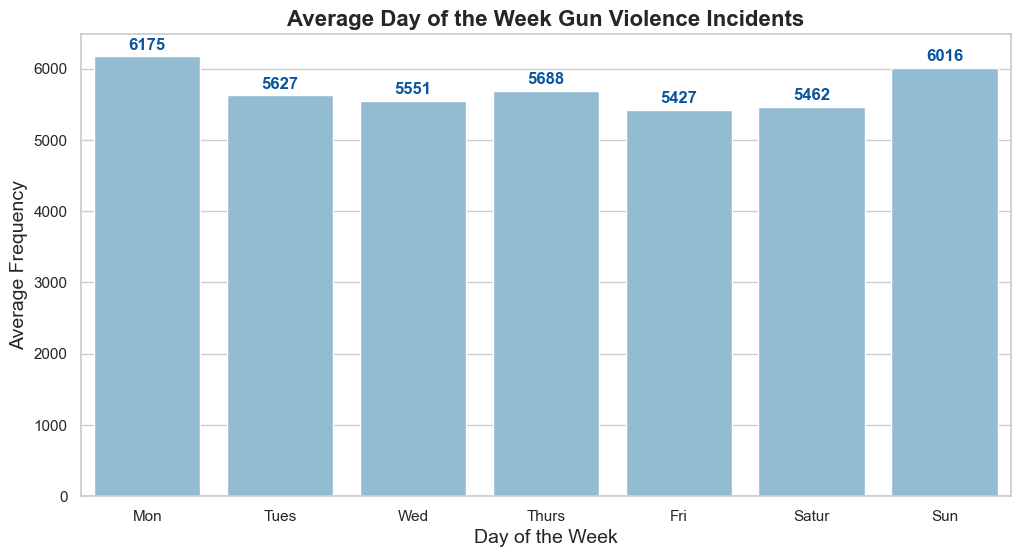

In [28]:
day_of_week_avg = pandas_ip_df.groupby('day_of_week').size() / pandas_ip_df['year'].nunique()
day_of_week_avg_df = day_of_week_avg.reset_index(name='average_incidents')
day_of_week_avg_df = day_of_week_avg_df.set_index('day_of_week').reindex([1, 2, 3, 4, 5, 6, 7]).reset_index()

plt.figure(figsize=(12, 6))
plot = sns.barplot(data=day_of_week_avg_df, x='day_of_week', y='average_incidents', color='#88BFDC')

week_names = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Satur", "Sun"]

plot.set_title("Average Day of the Week Gun Violence Incidents", fontsize=16, weight='bold')
plot.set_xlabel("Day of the Week", fontsize=14)
plot.set_ylabel("Average Frequency", fontsize=14)

plot.set_xticks(range(7))
plot.set_xticklabels(week_names)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='baseline', fontsize=12, color='#0B559F', 
                  xytext=(0, 5), textcoords='offset points', weight='bold')

plt.show()

Number of gun violence incidents are higher on `Sundays` and `Mondays` in the entire US on an average.

#### Time Series Analysis of Total Incidents, number of killings, number of injured

In [31]:
def plot_yearly_time_series(df, year):
    temp = df[df['year'] == year].groupby('date') \
                                .agg({'incident_id' : 'count', 'n_killed' : 'sum', 'n_injured' : 'sum'}) \
                                .reset_index().rename(columns={'incident_id' : 'incidents'})
    plt.figure(figsize=(12, 6))

    sns.lineplot(x='date', y='incidents', data=temp, label='Total Incidents', color='salmon')
    sns.lineplot(x='date', y='n_killed', data=temp, label='Total Killed', color='seagreen')
    sns.lineplot(x='date', y='n_injured', data=temp, label='Total Injured', color='steelblue')

    plt.title(f'Gun Violence Incidents - {year}', fontsize=16, weight='bold')
    plt.xlabel('Date Time', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Legend', loc='upper left')
    plt.tight_layout()

    plt.show()

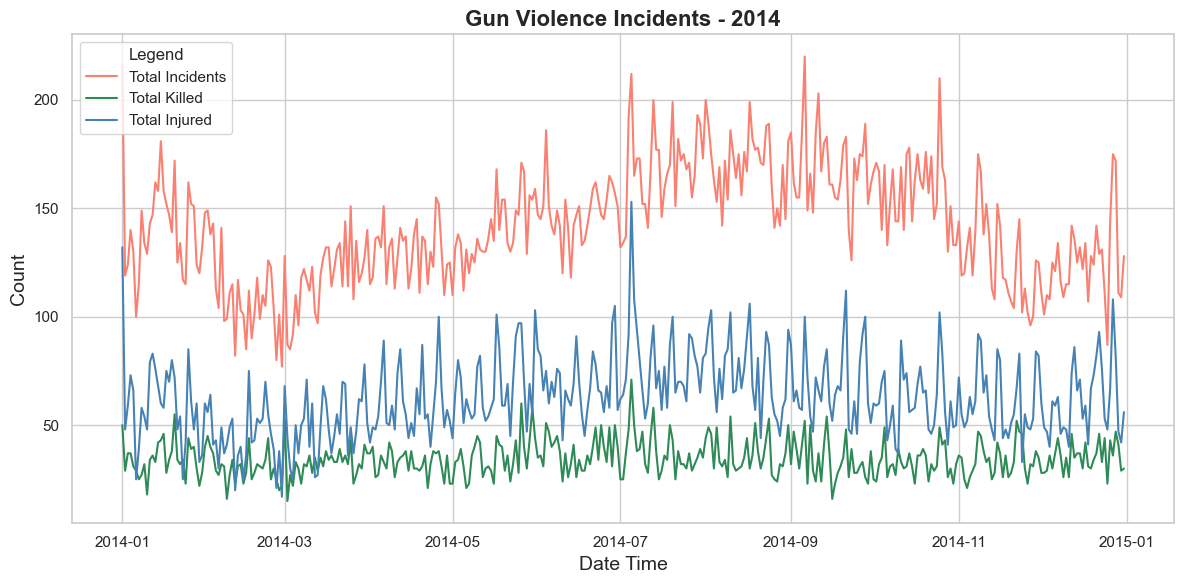

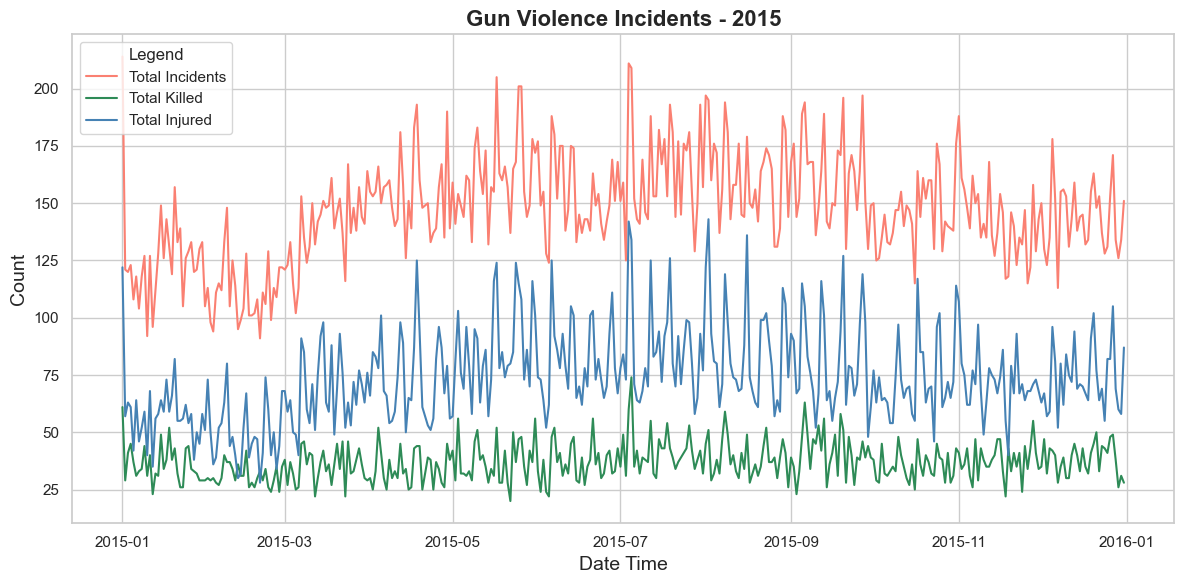

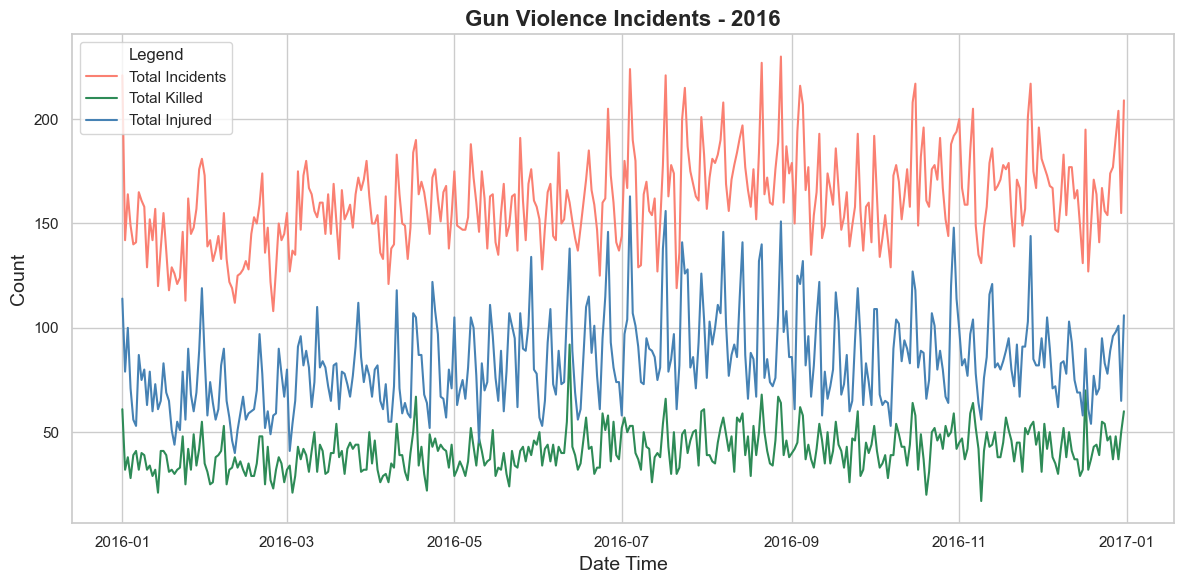

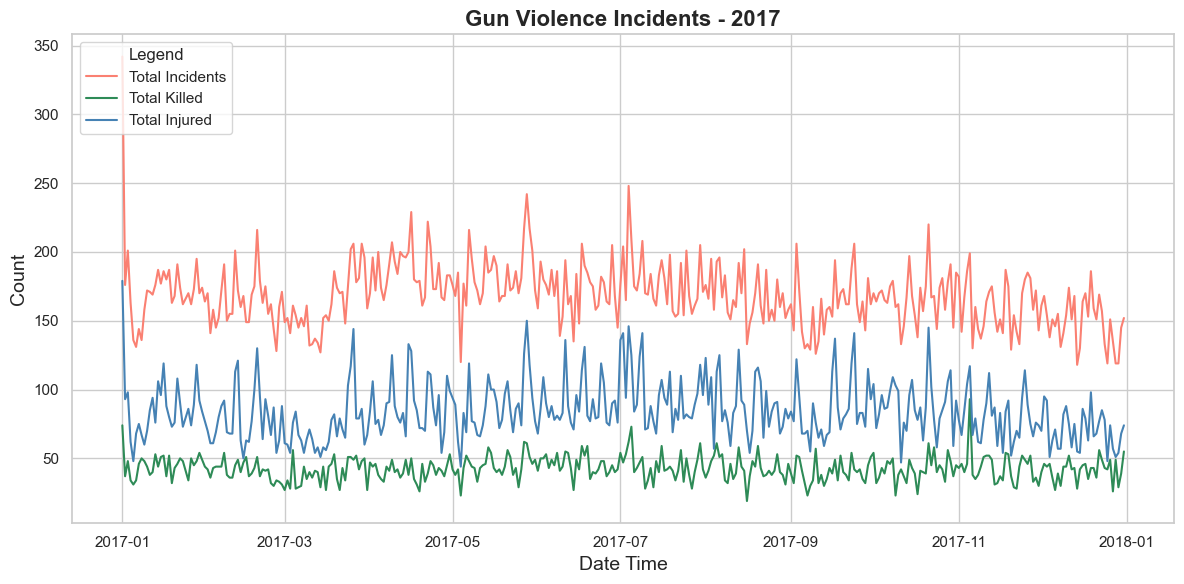

In [32]:
sorted_years = sorted(pandas_ip_df['year'].unique().tolist())
sorted_years = [year for year in sorted_years if year not in [2013, 2018]]

for year in sorted_years:
    plot_yearly_time_series(pandas_ip_df, year)

`Note`: 2013 and 2014 doesn't have full data so we can ignore those years in our analysis

From the analysis of the time series data for gun violence incidents from 2014 to 2017, we observe a distinct pattern of high gun violence incidents around July 4th and 5th each year. These dates, marking the celebration of Independence Day in the United States, consistently show the highest peaks in terms of total incidents, injuries, and deaths. This suggests that the holiday period around July 4th could be a time of increased gun violence, potentially influenced by the large gatherings, celebrations, and festivities associated with the holiday.

Here are the reported statistics for July 4th and July 5th from 2014 to 2017:

**July 4th:**
- **2014**: Total Incidents: 192, Total Injuries: 92, Total Killed: 48
- **2015**: Total Incidents: 211, Total Injuries: 142, Total Killed: 60
- **2016**: Total Incidents: 224, Total Injuries: 163, Total Killed: 53
- **2017**: Total Incidents: 248, Total Injuries: 146, Total Killed: 62

**July 5th:**
- **2014**: Total Incidents: 212
- **2015**: Total Incidents: 209
- **2016**: Total Incidents: 190
- **2017**: Total Incidents: 209

These numbers indicate a clear upward trend in gun violence incidents each year on these dates, with the figures continuing to rise from 2014 to 2017.

For reference, several articles have highlighted the relationship between holidays and increased violence, especially in cities like Chicago during the Fourth of July weekendtion could focus on the exact reasons behind these spikes—whether it's related to alcohol consumption, emotional stress, social conflicts, or other contributing factors.

### Exploration Location Trends

#### Incidents by every state

In [37]:
# gun_map = px.scatter_mapbox(pandas_ip_df, 
#                             lat="latitude", 
#                             lon="longitude", 
#                             hover_name="state", 
#                             hover_data={'city_or_county': True, 
#                                         'n_killed': True, 
#                                         'n_injured': True, 
#                                         'latitude': False, 
#                                         'longitude': False},
#                             color='n_killed',
#                             color_continuous_scale='geyser',
#                             zoom=2.8,
#                             size='n_killed',
#                             size_max=20,
#                             height=600,
#                             width=1000)

# gun_map.update_layout(mapbox_style="open-street-map")
# gun_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# gun_map.show()

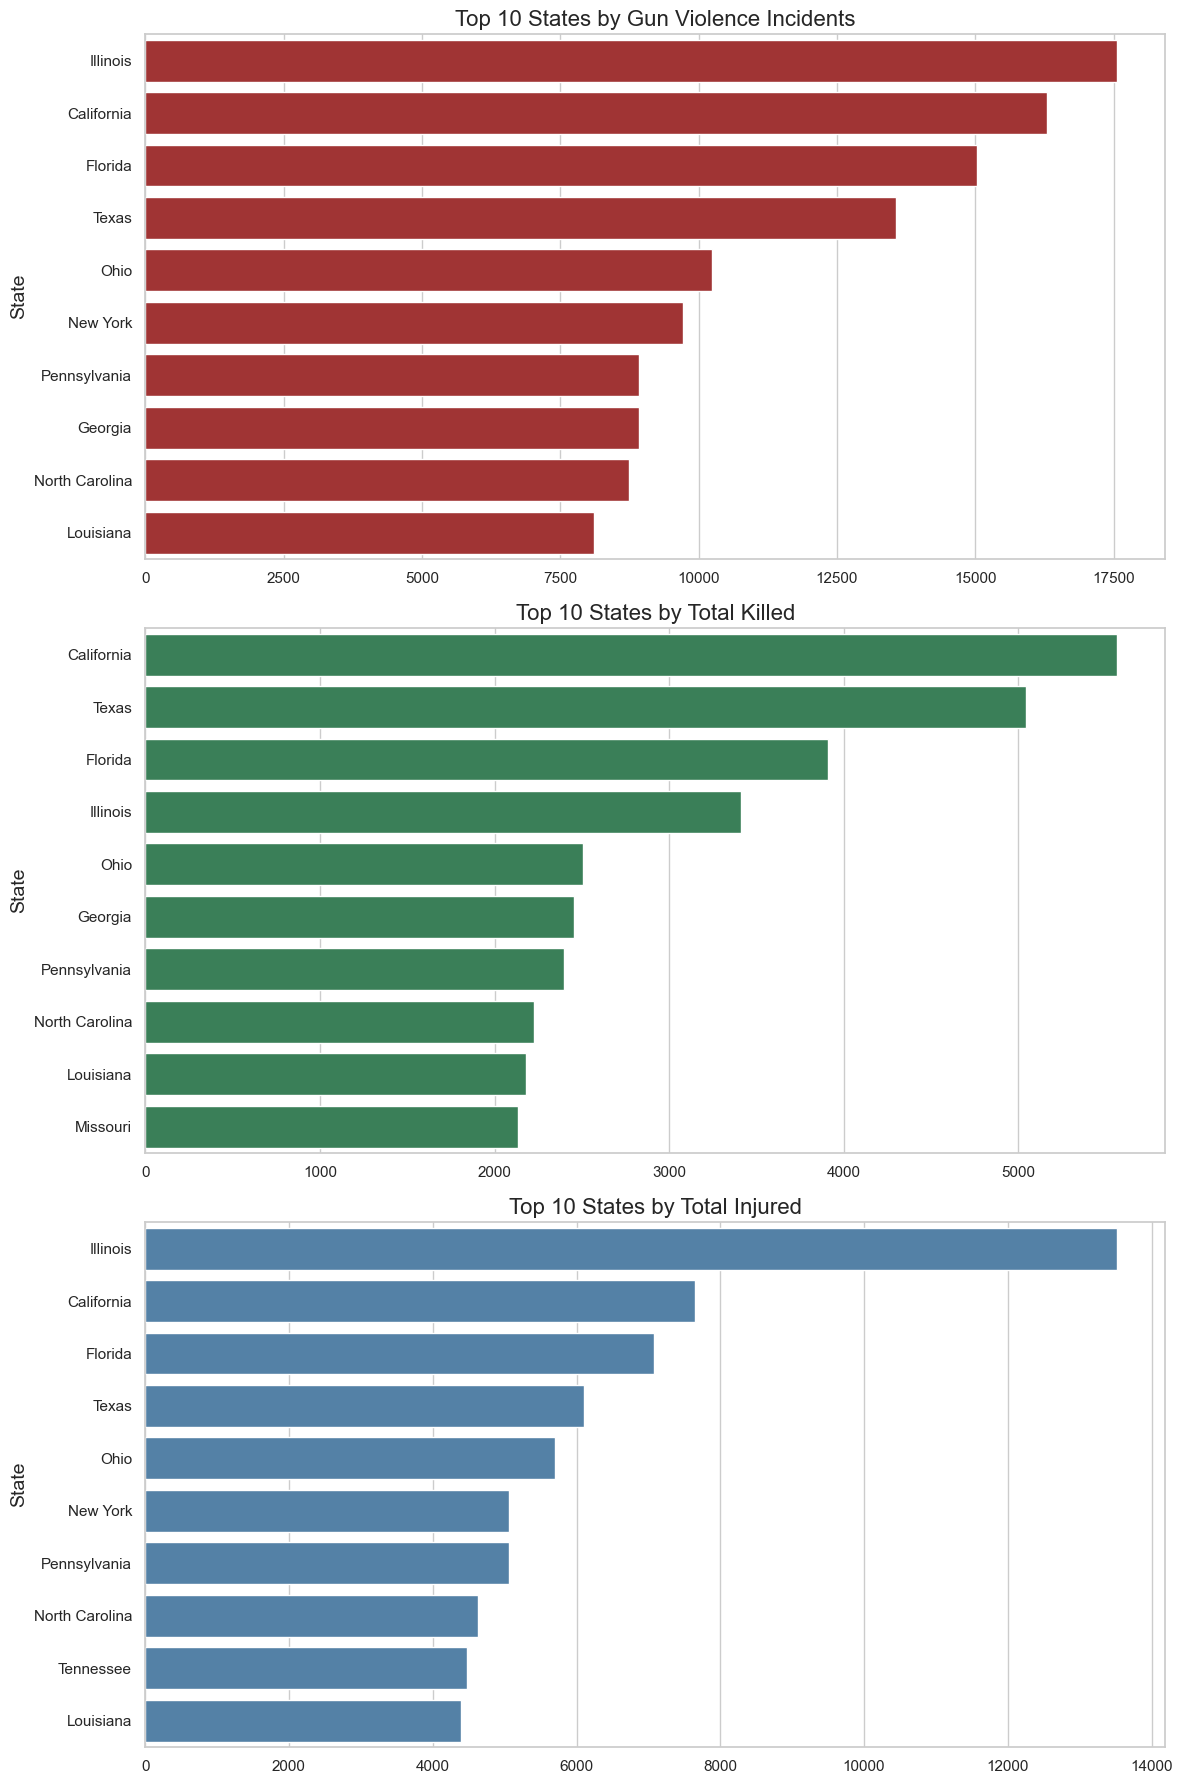

In [76]:
state_incidents = pandas_ip_df.groupby('state')['incident_id'].count().sort_values(ascending=False).head(10)
state_killed = pandas_ip_df.groupby('state')['n_killed'].sum().sort_values(ascending=False).head(10)
state_injured = pandas_ip_df.groupby('state')['n_injured'].sum().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.barplot(x=state_incidents.values, y=state_incidents.index, ax=axes[0], color='firebrick')
axes[0].set_title('Top 10 States by Gun Violence Incidents', fontsize=16)
# axes[0].set_xlabel('Total Incidents', fontsize=14)
axes[0].set_ylabel('State', fontsize=14)

sns.barplot(x=state_killed.values, y=state_killed.index, ax=axes[1], color='seagreen')
axes[1].set_title('Top 10 States by Total Killed', fontsize=16)
# axes[1].set_xlabel('Total Killed', fontsize=14)
axes[1].set_ylabel('State', fontsize=14)

sns.barplot(x=state_injured.values, y=state_injured.index, ax=axes[2], color='steelblue')
axes[2].set_title('Top 10 States by Total Injured', fontsize=16)
# axes[2].set_xlabel('Total Injured', fontsize=14)
axes[2].set_ylabel('State', fontsize=14)

plt.tight_layout()
plt.show()

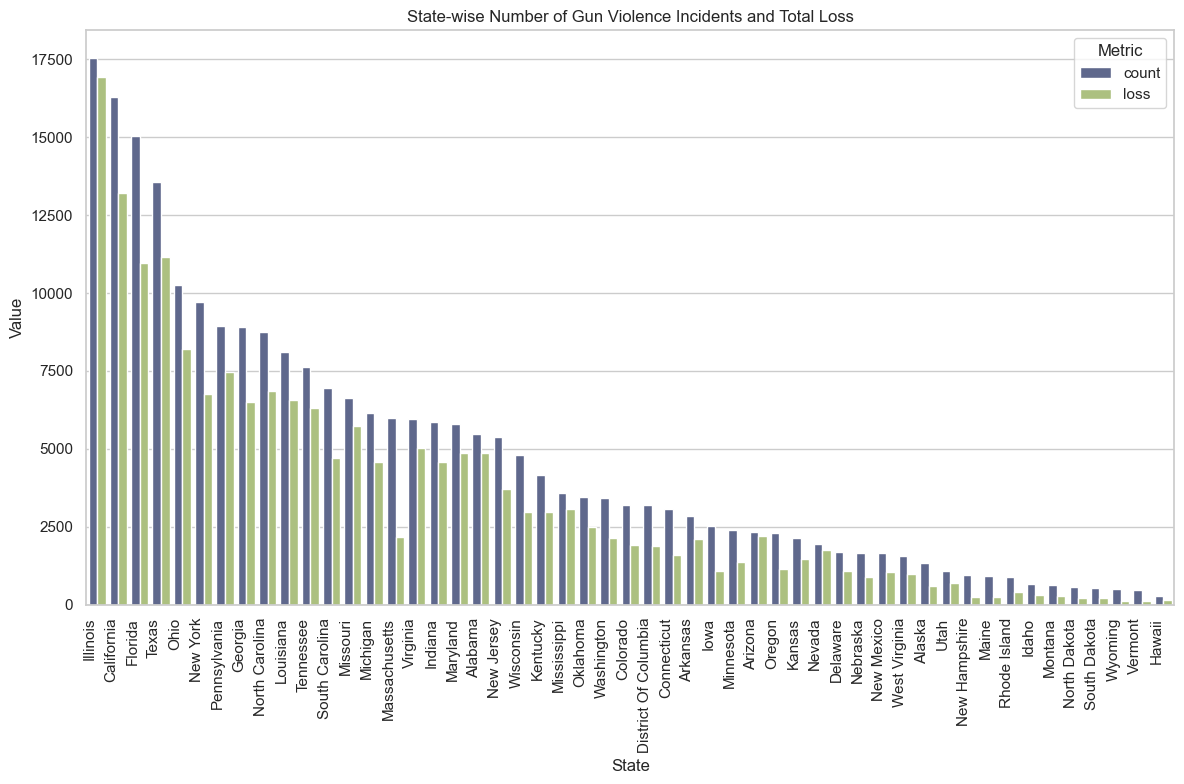

In [132]:
statdf = pandas_ip_df.groupby('state').agg({'loss': 'sum', 'year': 'count'}).rename(columns={'year': 'count'}).reset_index()
statdf_melted = statdf.melt(id_vars='state', value_vars=['count', 'loss'], var_name='metric', value_name='value')
statdf_melted = statdf_melted.sort_values(['metric', 'value'], ascending=[True, False])

plt.figure(figsize=(12, 8))
sns.barplot(data=statdf_melted, x='state', y='value', hue='metric', palette=['#586393', '#B0CB75'])

plt.xticks(rotation=90, ha='right')
plt.title('State-wise Number of Gun Violence Incidents and Total Loss')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

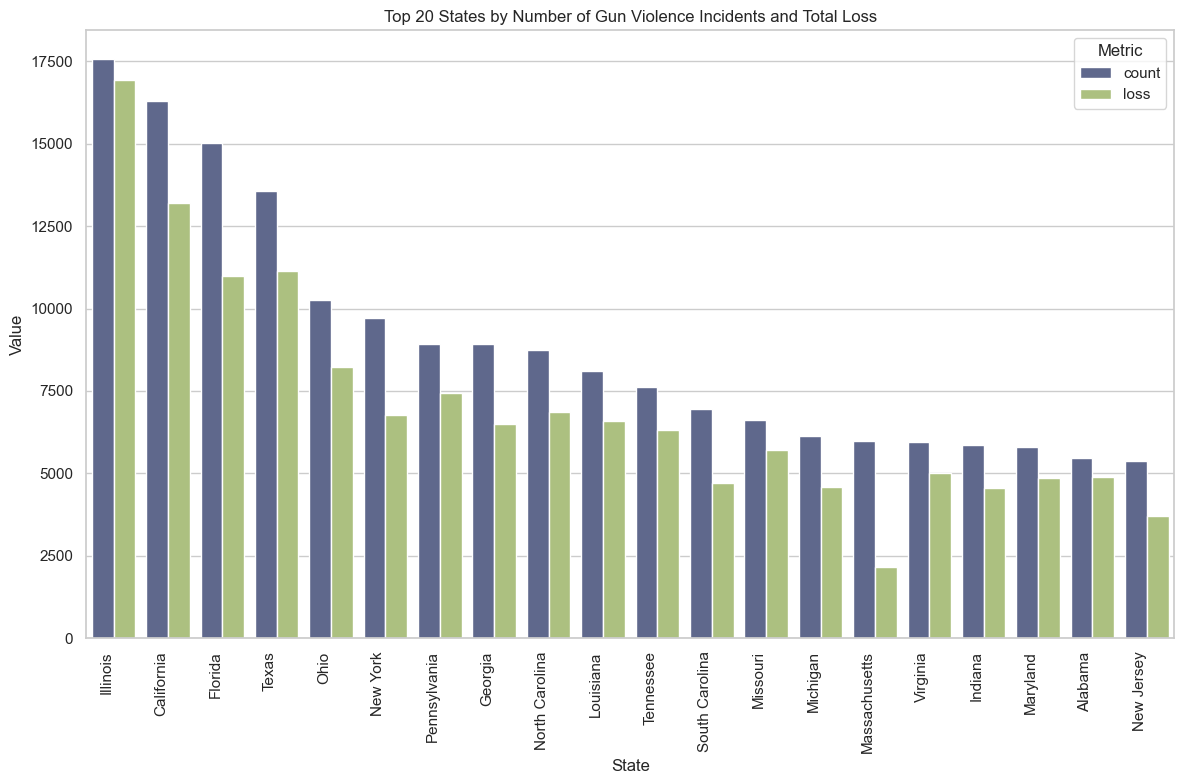

In [134]:
top_states_by_count = statdf.nlargest(20, 'count')

top_melted_cnt = top_states_by_count.melt(id_vars='state', value_vars=['count', 'loss'], var_name='metric', value_name='value')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_melted_cnt, x='state', y='value', hue='metric', palette=['#586393', '#B0CB75'])
plt.xticks(rotation=90, ha='right')
plt.title('Top 20 States by Number of Gun Violence Incidents and Total Loss')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

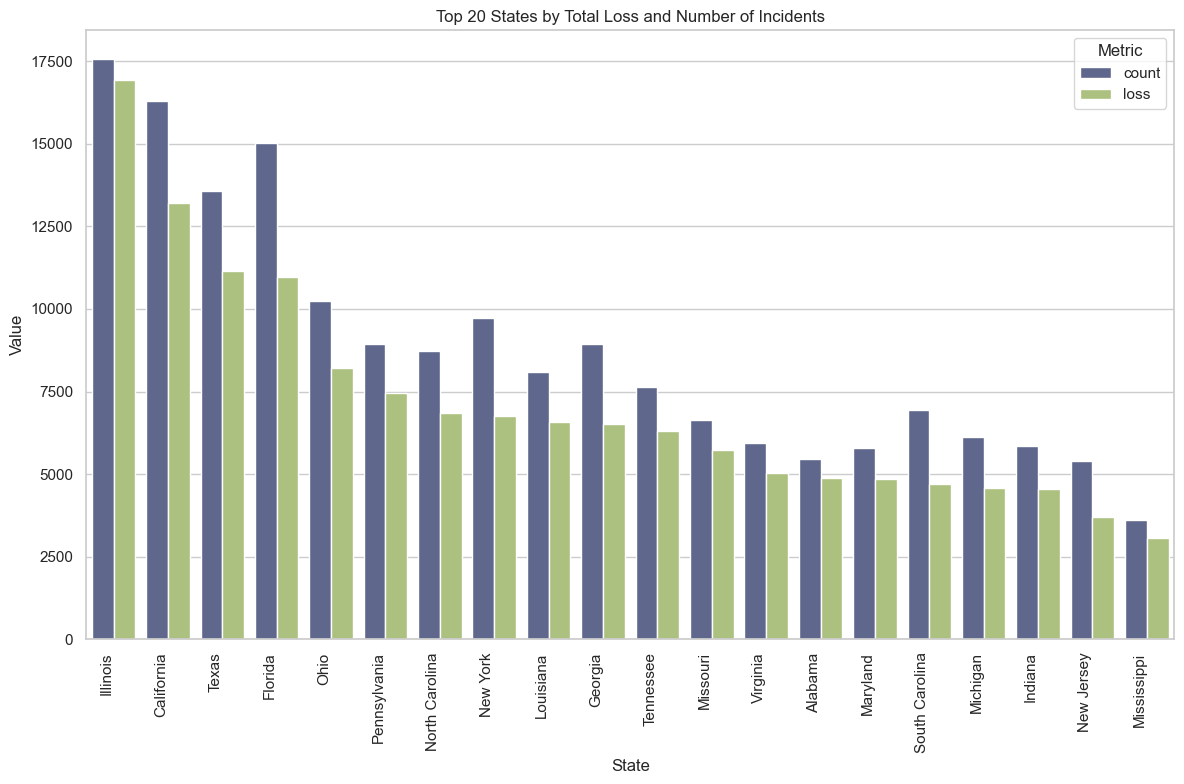

In [138]:
top_states_by_loss = statdf.nlargest(20, 'loss')

top_states_cnt = top_states_by_loss.melt(id_vars='state', value_vars=['count', 'loss'], var_name='metric', value_name='value')
plt.figure(figsize=(12, 8))
sns.barplot(data=top_states_cnt, x='state', y='value', hue='metric', palette=['#586393', '#B0CB75'])
plt.xticks(rotation=90, ha='right')
plt.title('Top 20 States by Total Loss and Number of Incidents')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

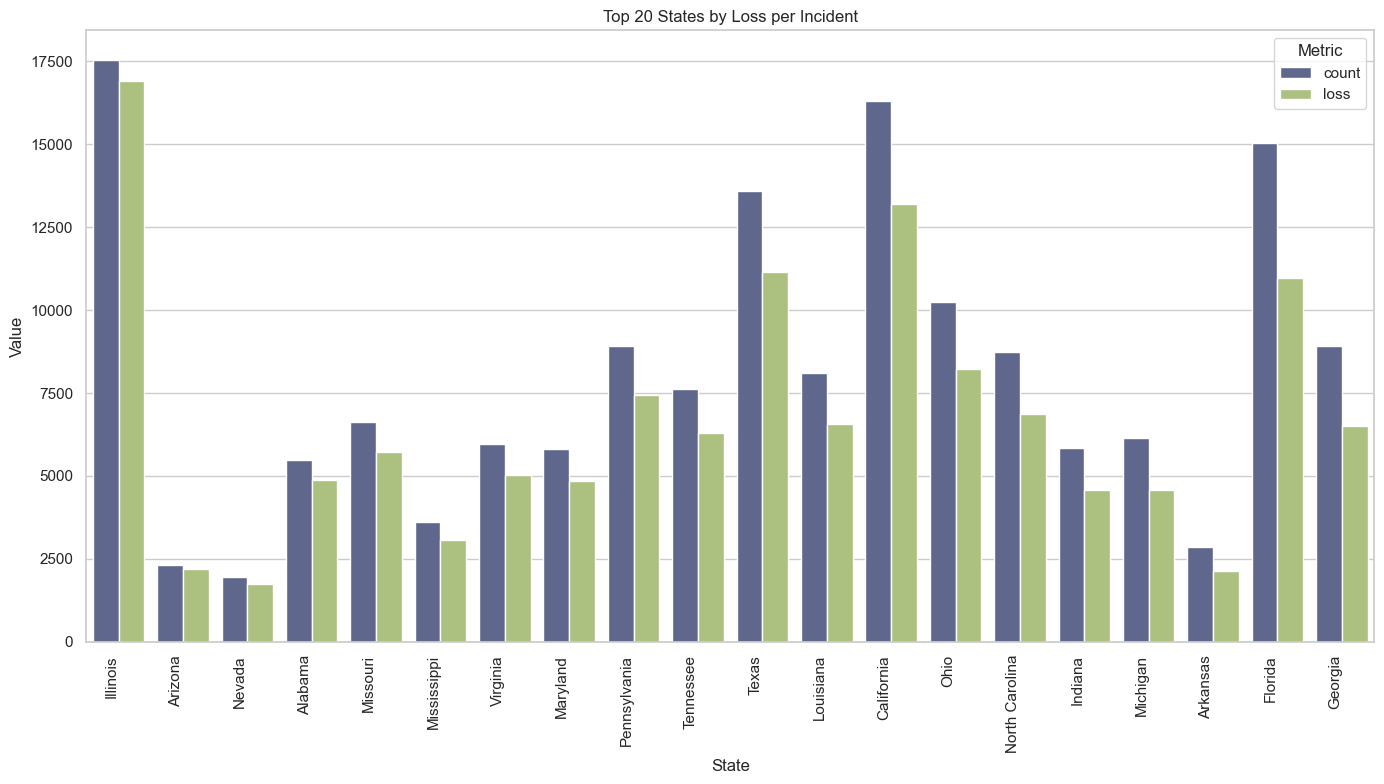

In [146]:
statdf['loss_per_incident'] = statdf['loss'] / statdf['count']
top_states_by_ratio = statdf.nlargest(20, 'loss_per_incident')

statdf_melted = top_states_by_ratio.melt(id_vars='state', value_vars=['count', 'loss'], 
                                         var_name='metric', value_name='value')
statdf_ratio = top_states_by_ratio[['state', 'loss_per_incident']]

plt.figure(figsize=(14, 8))
sns.barplot(data=statdf_melted, x='state', y='value', hue='metric', palette=['#586393', '#B0CB75'])

plt.xticks(rotation=90, ha='right')
plt.title('Top 20 States by Loss per Incident')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [148]:
ip_df_loss = pandas_ip_df.sort_values(['loss'], ascending=[False])
ip_df_loss[['date', 'state', 'city_or_county', 'address', 'n_killed', 'n_injured']].head(10)

,date,state,city_or_county,address,n_killed,n_injured
236875,2016-06-12,Florida,Orlando,1912 S Orange Ave,50,53
114694,2017-11-05,Texas,Sutherland Springs,216 4th St,27,20
159134,2015-12-02,California,San Bernardino,1365 South Waterman Ave,16,19
59040,2018-02-14,Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17
68054,2015-05-17,Texas,Waco,4671 S Jack Kultgen Fwy,9,18
24185,2017-07-01,Arkansas,Little Rock,220 W 6th St,0,25
76173,2016-07-25,Florida,Fort Myers,3580 Evans Ave,2,19
177282,2014-04-02,Texas,Fort Hood,Motor Pool Rd and Tank Destroyer Blvd,4,16
186959,2015-10-01,Oregon,Roseburg,1140 Umpqua College Rd,10,9
13148,2013-05-12,Louisiana,New Orleans,Frenchmen St,0,19


In [172]:
filter_kills_df = pandas_ip_df[pandas_ip_df['n_killed'] >= 3][['latitude', 'longitude', 'loss', 'n_killed']].dropna()
map1 = folium.Map(location=[39.50, -98.35], zoom_start=3.5, tiles='CartoDB Positron')

for _, row in filter_kills_df.iterrows():
    adjusted_loss = row['loss'] * 0.1 if row['loss'] > 100 else row['loss']
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=adjusted_loss,
        color='#F45046',
        fill=True,
        fill_opacity=0.7
    ).add_to(map1)

map1

In [174]:
# extra plot can be drawn with 1 and 2 having different colors

### Exploration of Gun Statistics

In [94]:
pandas_ip_df['n_guns'] = pandas_ip_df['n_guns_involved'].apply(lambda x: "10+" if x >= 10 else str(int(x)))
pandas_ip_df['n_guns'].value_counts()

n_guns
1      127548
0       99451
2        7477
3        2021
10+      1109
4         871
5         435
6         285
7         232
8         137
9         111
Name: count, dtype: int64

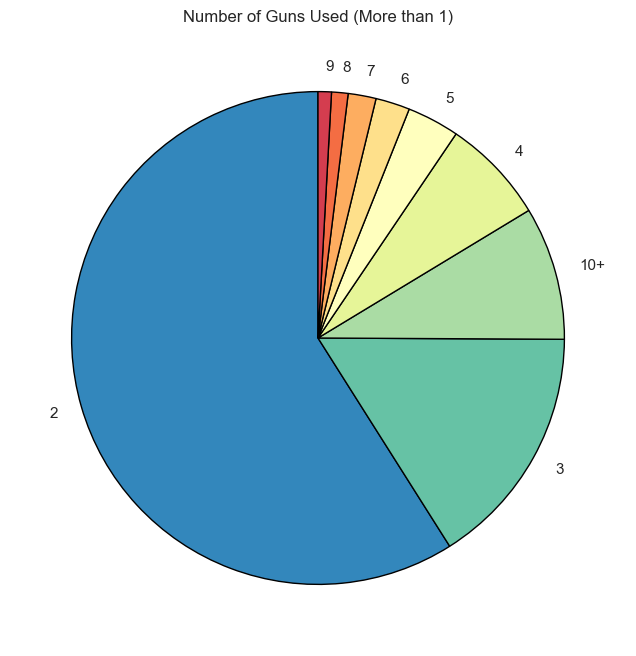

In [110]:
guns_df = pandas_ip_df['n_guns'].value_counts().reset_index()
guns_df.columns = ['n_guns', 'count']
guns_df = guns_df[(guns_df['n_guns'] != '0') & (guns_df['n_guns'] != '1')]

labels = guns_df['n_guns']
sizes = guns_df['count']

palette = sns.color_palette("Spectral", len(labels))
colors = palette.as_hex()[::-1]
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Number of Guns Used (More than 1)')
plt.show()

In [39]:
### Text Data - Location Description, Incident Characteristics

#### Visualizations

In [41]:
def analyze_participant_gender(df):
    """
    Analyzes participant demographics based on gender.

    Args:
        df: A Pandas DataFrame containing participant data.
    """
    # Sum the frequencies for each gender
    total_females = df['participant_gender_female_freq'].sum()
    total_males = df['participant_gender_male_freq'].sum()

    # Data for plotting
    genders = ['Female', 'Male']
    counts = [total_females, total_males]

    # Bar plot for total gender counts
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(genders, counts, color=['lightblue', 'salmon'])
    
    # Annotate value counts on bars
    for bar in bars:
        yval = bar.get_height()
        ax.annotate(f'{yval}', 
                    xy=(bar.get_x() + bar.get_width() / 2, yval), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)

    ax.set_title('Total Participants by Gender', fontsize=16)
    ax.set_ylabel('Total Count', fontsize=13)
    ax.set_xlabel('Gender', fontsize=13)
    plt.show()

def stacked_bar_plot(df):
    """
    Stacked bar plot for participant gender and status.

    Args:
        df: A Pandas DataFrame containing participant data.
    """
    # Prepare data for each status
    data = {
        'Female': [
            df['participant_gender_female_freq'][df['participant_status_arrested_freq'] > 0].sum(),
            df['participant_gender_female_freq'][df['participant_status_injured_freq'] > 0].sum(),
            df['participant_gender_female_freq'][df['participant_status_killed_freq'] > 0].sum(),
            df['participant_gender_female_freq'][df['participant_status_unharmed_freq'] > 0].sum(),
        ],
        'Male': [
            df['participant_gender_male_freq'][df['participant_status_arrested_freq'] > 0].sum(),
            df['participant_gender_male_freq'][df['participant_status_injured_freq'] > 0].sum(),
            df['participant_gender_male_freq'][df['participant_status_killed_freq'] > 0].sum(),
            df['participant_gender_male_freq'][df['participant_status_unharmed_freq'] > 0].sum(),
        ],
    }

    # Creating DataFrame
    df_status = pd.DataFrame(data, index=['Arrested', 'Injured', 'Killed', 'Unharmed'])

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = df_status.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'salmon'])

    ax.set_title('Participant Status by Gender', fontsize=16)
    ax.set_ylabel('Number of Participants', fontsize=13)
    ax.set_xlabel('Status', fontsize=13)
    ax.legend(title='Gender', fontsize=10)

    # Annotate value counts on bars
    for bar in ax.patches:
        height = bar.get_height()
        width = bar.get_width()
        x = bar.get_x() + width / 2
        y = bar.get_y() + height / 2
        ax.annotate(f'{int(height)}', 
                    xy=(x, y), 
                    ha='center', va='center', fontsize=10, color='black')

    plt.show()

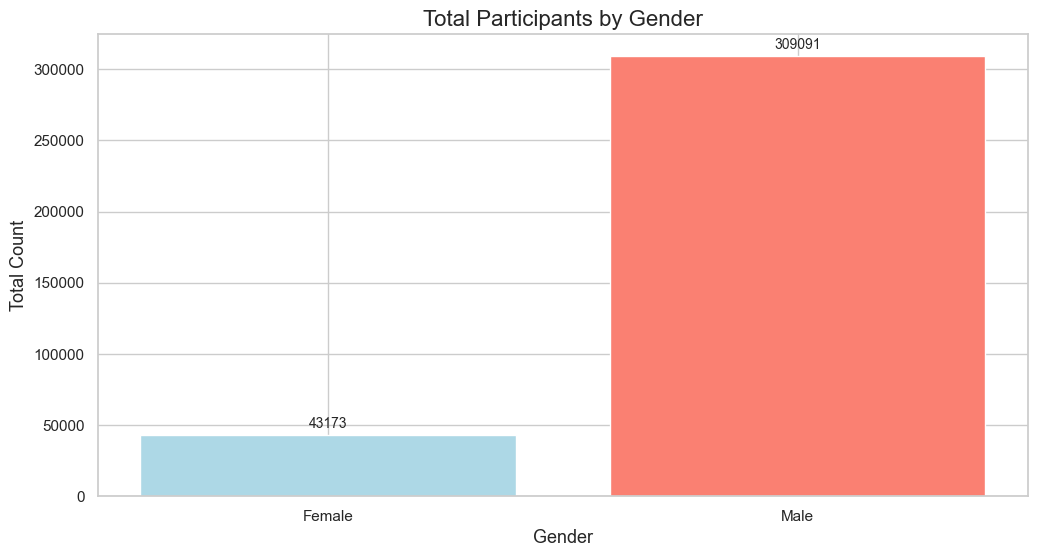

In [42]:
analyze_participant_gender(pandas_ip_df)

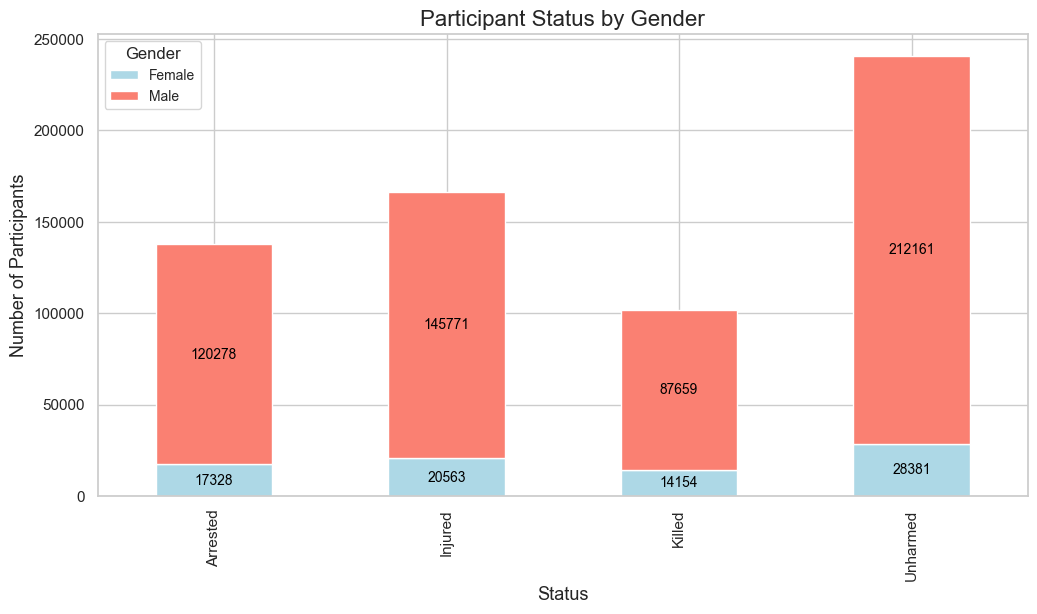

In [43]:
stacked_bar_plot(pandas_ip_df)

In [44]:
def status_frequency_plot(df):
    """
    Bar plot for participant statuses.

    Args:
        df: A Pandas DataFrame containing participant data.
    """
    status_counts = {
        'Arrested': df['participant_status_arrested_freq'].sum(),
        'Injured': df['participant_status_injured_freq'].sum(),
        'Killed': df['participant_status_killed_freq'].sum(),
        'Unharmed': df['participant_status_unharmed_freq'].sum(),
    }

    sorted_status_counts = dict(sorted(status_counts.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(sorted_status_counts.keys()), y=list(sorted_status_counts.values()), palette="Set2")
    plt.title('Total Participant Status Frequencies', fontsize=16)
    plt.xlabel('Status', fontsize=13)
    plt.ylabel('Total Frequency', fontsize=13)

    # Annotate values on bars
    for index, value in enumerate(sorted_status_counts.values()):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=12)

    plt.show()

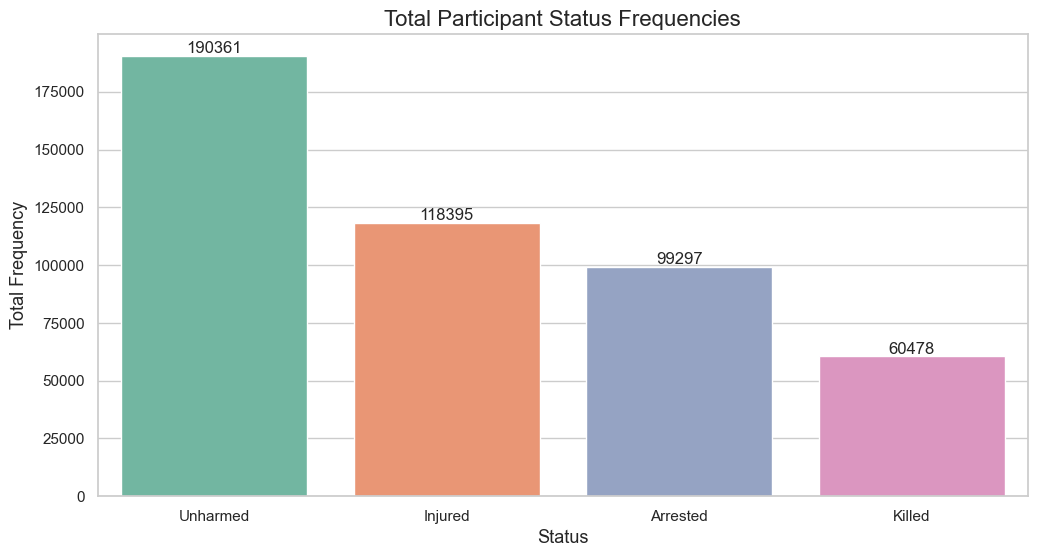

In [45]:
status_frequency_plot(pandas_ip_df)